# BackGround
- 주문 -> 결제 승인: 평균 약 0.44일 (약 10.5시간)
- 결제 승인 -> 배송사로 이동: 평균 약 2.85일
- 배송사 -> 고객 도착: 평균 약 9.19일
- 따라서 주문부터 고객에게 도착하기까지의 평균 시간은 약 13일 정도 소요

# 주마다 평균적으로 배송하는데 걸리는 시간

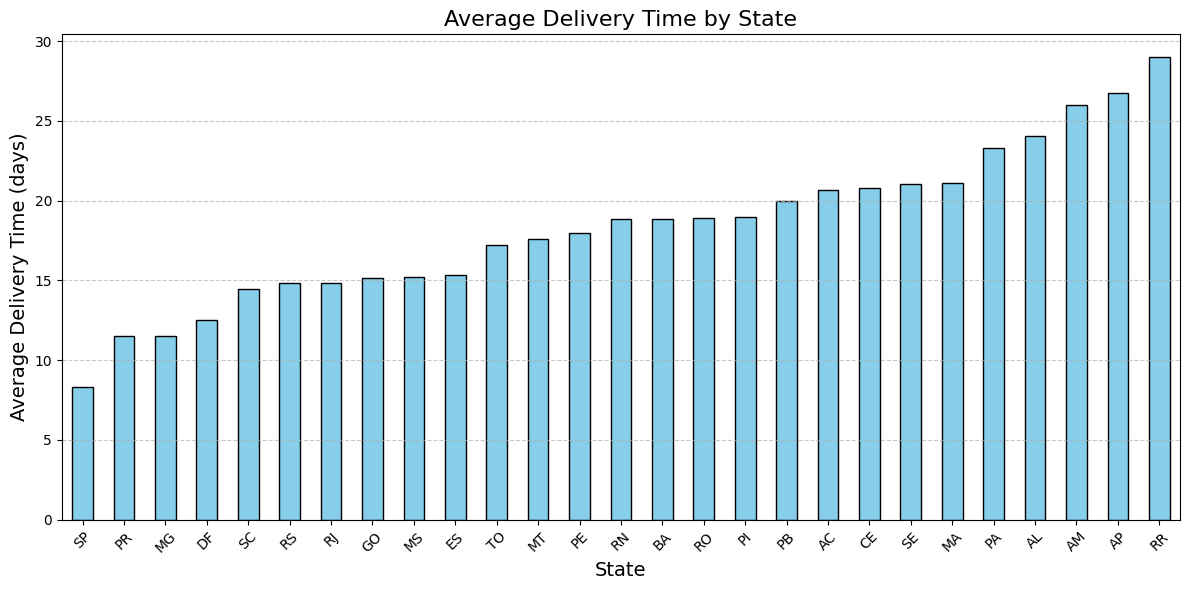

주(State)별 평균 배송 시간:
customer_state
SP     8.298061
PR    11.526711
MG    11.543813
DF    12.509135
SC    14.479560
RS    14.819237
RJ    14.849186
GO    15.150741
MS    15.191155
ES    15.331830
TO    17.226277
MT    17.593679
PE    17.965474
RN    18.824895
BA    18.866400
RO    18.913580
PI    18.993697
PB    19.953578
AC    20.637500
CE    20.817826
SE    21.029851
MA    21.117155
PA    23.316068
AL    24.040302
AM    25.986207
AP    26.731343
RR    28.975610
Name: delivery_time_days, dtype: float64


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: 데이터 로드
file_paths = {
    "customers": "olist_customers_dataset.csv",
    "geolocation": "olist_geolocation_dataset.csv",
    "orders": "olist_orders_dataset.csv"
}

# 데이터셋 불러오기
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# 데이터셋 분리
customers = datasets['customers']
geolocation = datasets['geolocation']
orders = datasets['orders']

# Step 2: 데이터 병합
# 고객 정보를 주문 데이터와 병합
orders_with_customers = pd.merge(orders, customers, on='customer_id', how='left')

# 우편번호를 기준으로 위치 정보를 병합
geolocation_reduced = geolocation.groupby('geolocation_zip_code_prefix').mean(numeric_only=True).reset_index()
orders_with_geo = pd.merge(orders_with_customers, geolocation_reduced, 
                           left_on='customer_zip_code_prefix', 
                           right_on='geolocation_zip_code_prefix', 
                           how='left')

# Step 3: 배송 시간 계산
# 날짜 컬럼 변환
date_columns = ['order_purchase_timestamp', 'order_delivered_customer_date']
for col in date_columns:
    orders_with_geo[col] = pd.to_datetime(orders_with_geo[col], errors='coerce')

# 배송 시간 (일 단위) 계산
orders_with_geo['delivery_time_days'] = (orders_with_geo['order_delivered_customer_date'] - orders_with_geo['order_purchase_timestamp']).dt.days

# 유효한 배송 시간 데이터 필터링
valid_delivery_times = orders_with_geo.dropna(subset=['delivery_time_days'])
valid_delivery_times = valid_delivery_times[valid_delivery_times['delivery_time_days'] >= 0]

# Step 4: 주(State)별 평균 배송 시간 계산
valid_delivery_times['delivery_time_days'] = pd.to_numeric(valid_delivery_times['delivery_time_days'], errors='coerce')
state_delivery_times = valid_delivery_times.groupby('customer_state')['delivery_time_days'].mean().sort_values()

# Step 5: 시각화
plt.figure(figsize=(12, 6))
state_delivery_times.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Delivery Time by State', fontsize=16)
plt.ylabel('Average Delivery Time (days)', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 6: 결과 출력
print("주(State)별 평균 배송 시간:")
print(state_delivery_times)


### 결과 분석
- 주마다 평균적으로 걸리는 시간은 굉장히 상이한 것으로 드러남.
- 10일도 안걸리는 주가 있는 반면, 한달가량이 걸리는 주도 존재

# 주마다 배송량 계산

   customer_state  order_count
0              SP        40495
1              RJ        12353
2              MG        11355
3              RS         5344
4              PR         4923
5              SC         3547
6              BA         3256
7              DF         2080
8              ES         1995
9              GO         1957
10             PE         1593
11             CE         1279
12             PA          946
13             MT          886
14             MA          717
15             MS          701
16             PB          517
17             PI          476
18             RN          474
19             AL          397
20             SE          335
21             TO          274
22             RO          243
23             AM          145
24             AC           80
25             AP           67
26             RR           41


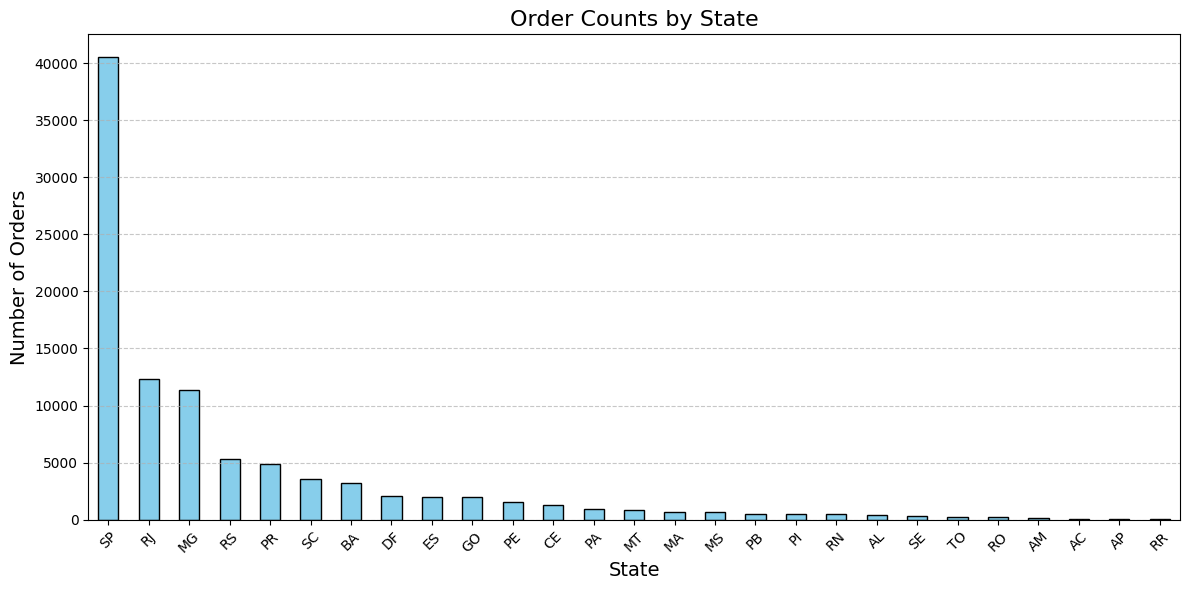

In [3]:
# 주(State)별 주문량 계산
state_order_counts = valid_delivery_times.groupby('customer_state')['order_id'].count().sort_values(ascending=False)

# 결과를 데이터프레임 형태로 변환
state_order_counts_df = state_order_counts.reset_index().rename(columns={'order_id': 'order_count'})

# 결과 출력
print(state_order_counts_df)

# 시각화 (주문량)
state_order_counts.plot(kind='bar', figsize=(12, 6), color='skyblue', edgecolor='black')
plt.title('Order Counts by State', fontsize=16)
plt.ylabel('Number of Orders', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 결과 분석
- 배송기간이 제일 짧게 걸리는 주가 주문량이 압도적으로 많았음.
- 다른 주들에서는 주문량이 몇배씩 차이가 나기 때문에 배송소요 기간이 평균 12일 정도가 나올 수 있었음
- 따라서 배송 일 수의 차이에 의해서 주문량이 많이 차이날 수 있음
- 10일대 초반까지는 주문량이 어느정도 있는 반면, 10일대 중반까지 가더라도 주문량이 확 꺾여버림.
- 따라서 주문하고 배송하는데 걸리는 일수를 10일대 초반까지 당겨야 할 필요가 있음. 

# 배송 과정 세분화
주문부터 고객에게 배송하기까지 단계별로 얼마나 걸리는지 시각화

주(State)별 각 단계 평균 소요 시간:
                purchase_to_approval_avg  approval_to_carrier_avg  \
customer_state                                                      
AC                              0.632060                 2.846986   
AL                              0.488749                 2.969874   
AM                              0.406744                 2.499724   
AP                              0.639487                 2.882057   
BA                              0.486384                 2.811486   
CE                              0.470245                 2.863095   
DF                              0.426476                 2.737606   
ES                              0.441570                 2.941078   
GO                              0.525470                 2.643198   
MA                              0.578156                 3.024596   
MG                              0.414672                 2.822378   
MS                              0.440477                 2.725268   
MT       

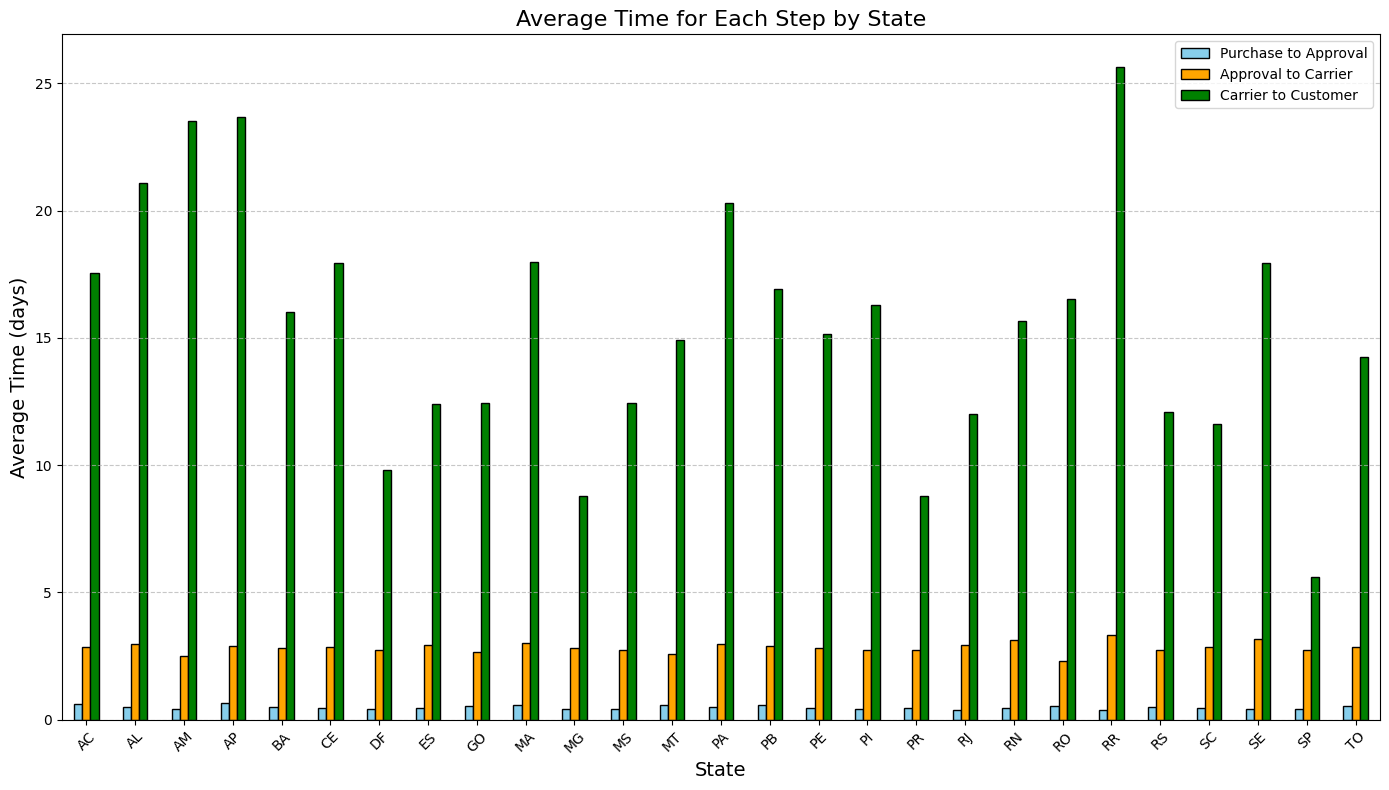

In [5]:
# 날짜 컬럼을 올바른 datetime 형식으로 변환
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']
for col in date_columns:
    valid_delivery_times[col] = pd.to_datetime(valid_delivery_times[col], errors='coerce')

# 각 과정에서 소요 시간을 계산 (시간 단위)
valid_delivery_times['purchase_to_approval'] = (valid_delivery_times['order_approved_at'] - valid_delivery_times['order_purchase_timestamp']).dt.total_seconds() / 3600
valid_delivery_times['approval_to_carrier'] = (valid_delivery_times['order_delivered_carrier_date'] - valid_delivery_times['order_approved_at']).dt.total_seconds() / 3600
valid_delivery_times['carrier_to_customer'] = (valid_delivery_times['order_delivered_customer_date'] - valid_delivery_times['order_delivered_carrier_date']).dt.total_seconds() / 3600

# 시간(시간 단위)을 일(day) 단위로 변환
valid_delivery_times['purchase_to_approval_days'] = valid_delivery_times['purchase_to_approval'] / 24
valid_delivery_times['approval_to_carrier_days'] = valid_delivery_times['approval_to_carrier'] / 24
valid_delivery_times['carrier_to_customer_days'] = valid_delivery_times['carrier_to_customer'] / 24

# 주(State)별 평균 소요 시간 계산
state_times = valid_delivery_times.groupby('customer_state').agg(
    purchase_to_approval_avg=('purchase_to_approval_days', 'mean'),
    approval_to_carrier_avg=('approval_to_carrier_days', 'mean'),
    carrier_to_customer_avg=('carrier_to_customer_days', 'mean')
).sort_index()

# 결과 출력
print("주(State)별 각 단계 평균 소요 시간:")
print(state_times)

# 시각화 (단계별 소요 시간 비교)
state_times.plot(kind='bar', figsize=(14, 8), color=['skyblue', 'orange', 'green'], edgecolor='black')
plt.title('Average Time for Each Step by State', fontsize=16)
plt.ylabel('Average Time (days)', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.xticks(rotation=45)
plt.legend(['Purchase to Approval', 'Approval to Carrier', 'Carrier to Customer'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 결과 분석
- 주문->승인->택배사 도착까지는 모두 문제없이 동일하나, 배송사에서 고객에게 전달하는 것이 지역볼로 크게 차이가 남.
- 따라서 각 지역마다 배송 인프라를 잘 구축하는 것이 필요해보임. 

# 셀러의 지역과 배송 기간의 상관관계

판매자 지역별 평균 배송 기간:
seller_state
RS    11.092208
RJ    11.554916
SP    11.811387
MS    11.900000
DF    12.088335
PB    12.162162
SE    12.200000
MG    12.329691
GO    12.370079
ES    12.417582
PE    12.496629
RN    12.642857
PR    12.921763
SC    13.095500
PA    13.125000
PI    13.272727
BA    13.413462
MT    14.256944
RO    16.928571
MA    17.271144
CE    17.433333
AM    47.333333
Name: delivery_time_days, dtype: float64


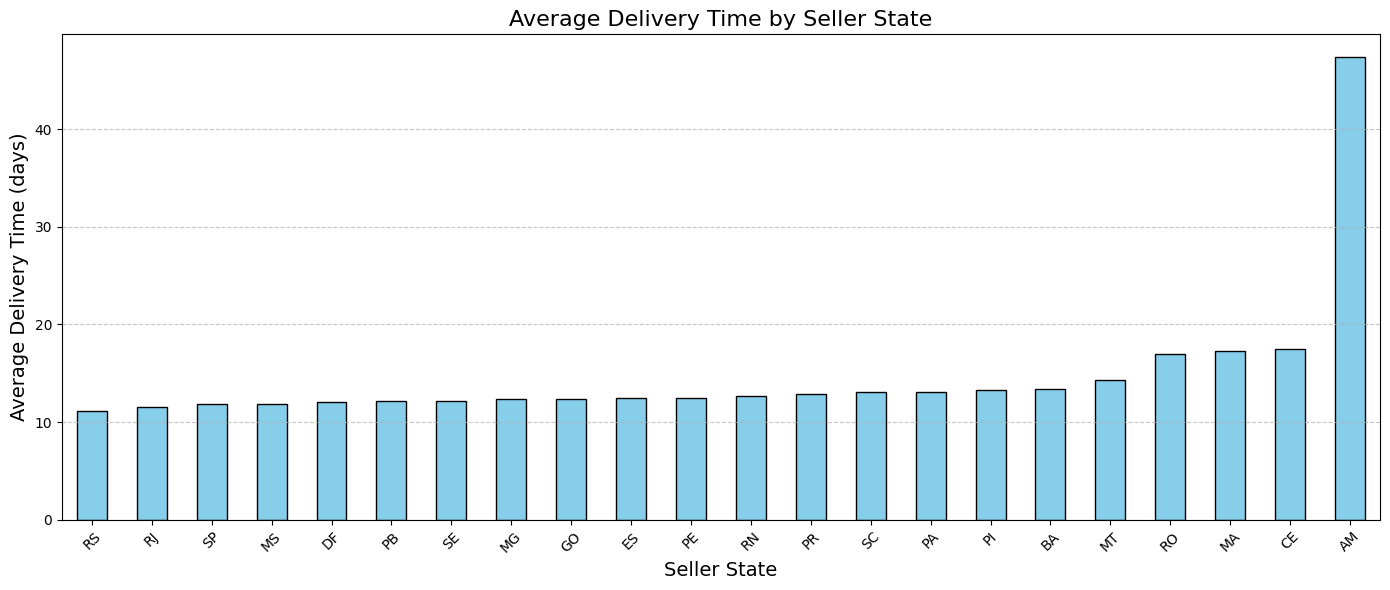

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: 데이터 불러오기
file_paths = {
    "order_items": "olist_order_items_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "orders": "olist_orders_dataset.csv"
}

# 데이터 로드
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# 데이터셋 할당
order_items = datasets['order_items']
sellers = datasets['sellers']
orders = datasets['orders']

# Step 2: 데이터 병합
# 주문 아이템과 판매자 정보 병합
order_items_with_sellers = pd.merge(order_items, sellers, on='seller_id', how='left')

# 주문 데이터와 병합하여 배송 정보 포함
orders_with_sellers = pd.merge(order_items_with_sellers, orders, on='order_id', how='left')

# Step 3: 날짜 컬럼 변환 및 배송 시간 계산
# 날짜 컬럼을 datetime 형식으로 변환
date_columns = ['order_purchase_timestamp', 'order_delivered_customer_date']
for col in date_columns:
    orders_with_sellers[col] = pd.to_datetime(orders_with_sellers[col], errors='coerce')

# 배송 시간 계산 (일 단위)
orders_with_sellers['delivery_time_days'] = (orders_with_sellers['order_delivered_customer_date'] - orders_with_sellers['order_purchase_timestamp']).dt.days

# 유효한 배송 시간 데이터만 필터링
valid_delivery_data = orders_with_sellers.dropna(subset=['delivery_time_days'])
valid_delivery_data = valid_delivery_data[valid_delivery_data['delivery_time_days'] >= 0]

# Step 4: 판매자 지역(seller_state)별 평균 배송 기간 계산
seller_state_delivery = valid_delivery_data.groupby('seller_state')['delivery_time_days'].mean().sort_values()

# Step 5: 결과 출력
print("판매자 지역별 평균 배송 기간:")
print(seller_state_delivery)

# Step 6: 시각화
plt.figure(figsize=(14, 6))
seller_state_delivery.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Delivery Time by Seller State', fontsize=16)
plt.xlabel('Seller State', fontsize=14)
plt.ylabel('Average Delivery Time (days)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 결과 분석
- 셀러의 지역별로 배송 기간은 크게 차이가 나지 않는다.
- 하지만 이는 SP 지역으로의 배송이 몰렸기 때문에 나타나는 현상일 가능성이 높음.

# 판매자와 소비자의 지역별로 배송에 걸리는 시간

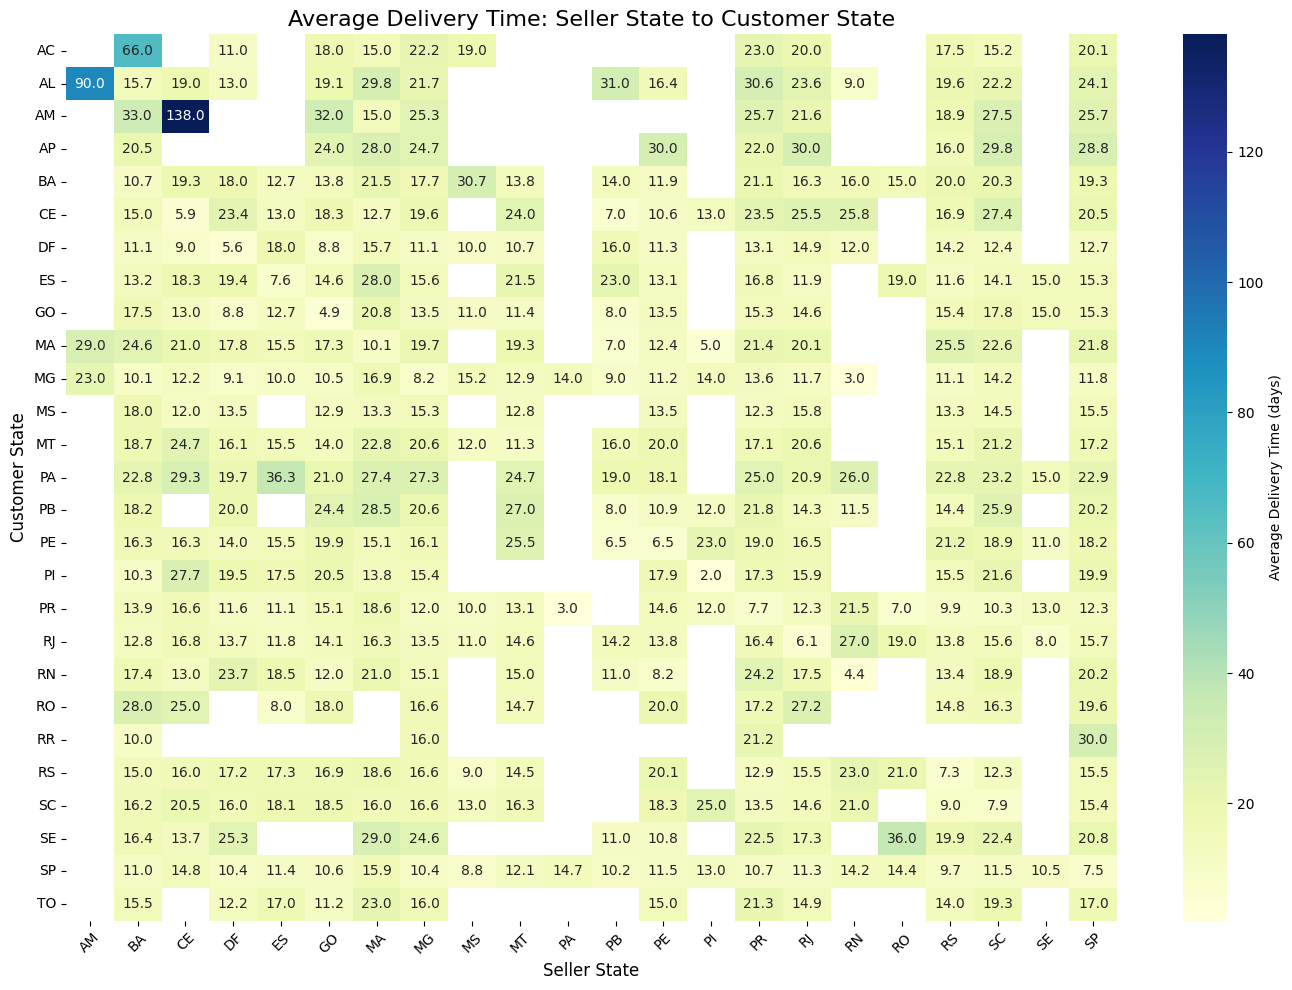

15일 이상 걸리는 판매자-소비자 지역 조합:
    seller_state customer_state  delivery_time_days
0             AM             AL           90.000000
1             AM             MA           29.000000
2             AM             MG           23.000000
3             BA             AC           66.000000
4             BA             AL           15.700000
..           ...            ...                 ...
406           SP             RR           30.027027
407           SP             RS           15.514638
408           SP             SC           15.353267
409           SP             SE           20.848101
411           SP             TO           17.035398

[236 rows x 3 columns]

판매자 지역이 등장한 횟수:
seller_state
SP    23
MG    21
PR    20
MA    19
SC    18
BA    17
RJ    16
CE    14
GO    14
RS    13
DF    12
ES    10
PE     8
MT     7
RN     7
PB     5
RO     4
AM     3
MS     3
PI     2
Name: count, dtype: int64


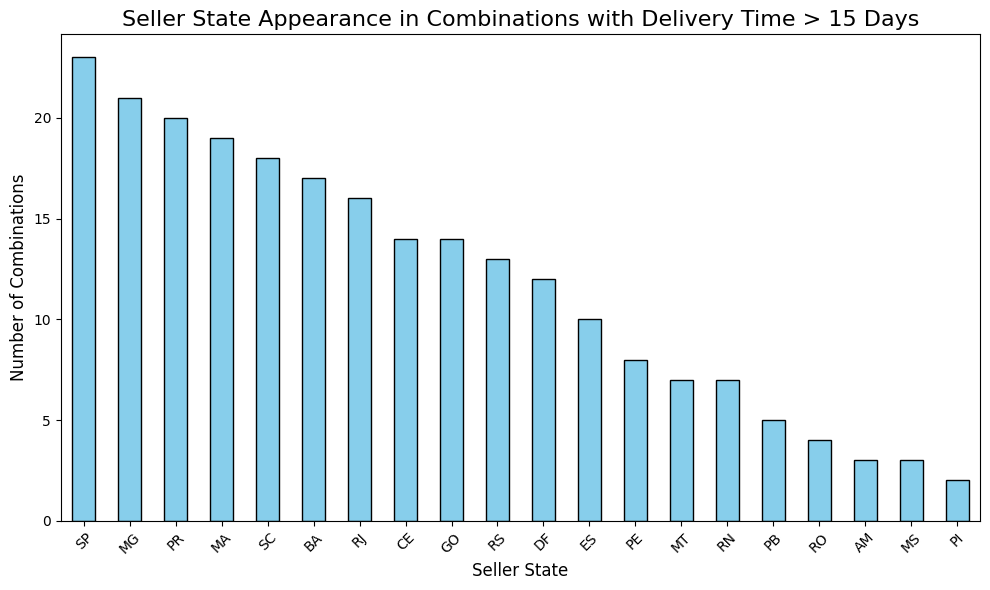

15일 이하 걸리는 판매자-소비자 지역 조합:
    seller_state customer_state  delivery_time_days
7             BA             BA           10.662162
8             BA             CE           15.000000
9             BA             DF           11.055556
10            BA             ES           13.230769
13            BA             MG           10.094340
..           ...            ...                 ...
384           SE             SP           10.500000
391           SP             DF           12.723323
395           SP             MG           11.824346
402           SP             PR           12.303408
410           SP             SP            7.461462

[176 rows x 3 columns]

판매자 지역이 등장한 횟수:
seller_state
PE    16
RS    13
MT    12
GO    11
DF    11
PB    11
RJ    10
BA    10
ES     9
CE     8
SC     8
MS     8
PI     7
SE     7
PR     7
MG     6
MA     6
RN     6
SP     4
PA     3
RO     3
Name: count, dtype: int64


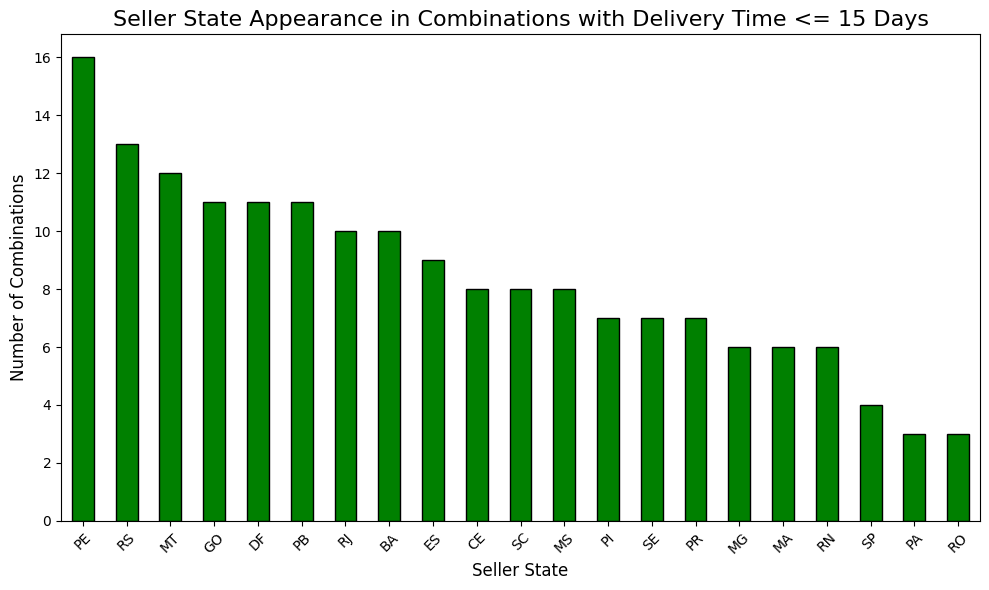

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: 데이터 불러오기
file_paths = {
    "order_items": "olist_order_items_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "orders": "olist_orders_dataset.csv",
    "customers": "olist_customers_dataset.csv"
}

# 데이터 로드
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# 데이터셋 할당
order_items = datasets['order_items']
sellers = datasets['sellers']
orders = datasets['orders']
customers = datasets['customers']

# Step 2: 데이터 병합
# 주문 아이템에 판매자 정보 병합
order_items_with_sellers = pd.merge(order_items, sellers, on='seller_id', how='left')

# 주문 데이터에 고객 정보 병합
orders_with_customers = pd.merge(orders, customers, on='customer_id', how='left')

# 모든 데이터를 병합
complete_data = pd.merge(order_items_with_sellers, orders_with_customers, on='order_id', how='left')

# Step 3: 날짜 컬럼 변환 및 배송 시간 계산
# 날짜 컬럼을 datetime 형식으로 변환
date_columns = ['order_purchase_timestamp', 'order_delivered_customer_date']
for col in date_columns:
    complete_data[col] = pd.to_datetime(complete_data[col], errors='coerce')

# 배송 시간 계산 (일 단위)
complete_data['delivery_time_days'] = (complete_data['order_delivered_customer_date'] - complete_data['order_purchase_timestamp']).dt.days

# 유효한 데이터만 필터링
valid_data = complete_data.dropna(subset=['delivery_time_days'])
valid_data = valid_data[valid_data['delivery_time_days'] >= 0]

# Step 4: 판매자 주 → 소비자 주별 평균 배송 시간 계산
seller_to_customer_delivery = valid_data.groupby(['seller_state', 'customer_state'])['delivery_time_days'].mean().reset_index()

# Step 5: 피벗 테이블 생성
pivot_table = seller_to_customer_delivery.pivot_table(
    index='customer_state', 
    columns='seller_state', 
    values='delivery_time_days', 
    aggfunc='mean'
)

# Step 6: 히트맵 시각화
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Average Delivery Time (days)'})
plt.title('Average Delivery Time: Seller State to Customer State', fontsize=16)
plt.xlabel('Seller State', fontsize=12)
plt.ylabel('Customer State', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 1: 15일 이상 걸리는 판매자-소비자 지역 조합 필터링
long_delivery_combinations = seller_to_customer_delivery[seller_to_customer_delivery['delivery_time_days'] > 15]

# Step 2: 판매자 지역(seller_state) 등장 횟수 계산
seller_state_counts = long_delivery_combinations['seller_state'].value_counts()

# Step 3: 결과 출력
print("15일 이상 걸리는 판매자-소비자 지역 조합:")
print(long_delivery_combinations)

print("\n판매자 지역이 등장한 횟수:")
print(seller_state_counts)

# Step 4: 시각화 (판매자 지역 등장 횟수)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
seller_state_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Seller State Appearance in Combinations with Delivery Time > 15 Days', fontsize=16)
plt.xlabel('Seller State', fontsize=12)
plt.ylabel('Number of Combinations', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 1: 15일 이하 걸리는 판매자-소비자 지역 조합 필터링
short_delivery_combinations = seller_to_customer_delivery[seller_to_customer_delivery['delivery_time_days'] <= 15]

# Step 2: 판매자 지역(seller_state) 등장 횟수 계산
seller_state_counts = short_delivery_combinations['seller_state'].value_counts()

# Step 3: 결과 출력
print("15일 이하 걸리는 판매자-소비자 지역 조합:")
print(short_delivery_combinations)

print("\n판매자 지역이 등장한 횟수:")
print(seller_state_counts)

# Step 4: 시각화 (판매자 지역 등장 횟수)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
seller_state_counts.plot(kind='bar', color='green', edgecolor='black')
plt.title('Seller State Appearance in Combinations with Delivery Time <= 15 Days', fontsize=16)
plt.xlabel('Seller State', fontsize=12)
plt.ylabel('Number of Combinations', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 결과 분석
히트맵
- 이상치때문에 색깔이 비슷해보이지만, 축을 보면 알 수 있듯이 조금의 색깔 차이도 큰 숫자 차이라서 예민하게 봐야함
- 히트맵 결과를 토대로 배송하는데 15일이 넘는 판매자지역-소비자지역 조합을 찾고, 판매자 지역이 각각 몇 번 등장했는지 보여주는 시각화를 진행
- 주문량이 너무 많은 SP지역은 제외하고 봐야함.
- SP-SP로 시키는 택배 물량을 제외하고 다른 모든 지역으로 갈 때 배송일이 대부분 15일이 넘었음.
- 또한 소비자가 SP에 거주하고 있으면, 배송을 받는데 걸리는 시간이 평균 15일 미만으로 굉장히 안정적임.
- 따라서 SP로 가는 택배는 문제가 없음
- 또한 15일 미만의 판매자 지역을 보았을 때 특정 지역끼리의 배송 체계는 잘 갖춰져있는 경우도 있는 것 같음

# 배송 기간과 배송 비용 관련 시각화

판매자 주(State)별 평균 배송 시간 및 운송비 요약:
              average_delivery_time_days  average_freight_value
seller_state                                                   
AM                             47.333333              27.266667
BA                             13.413462              30.803558
CE                             17.433333              46.735667
DF                             12.088335              20.444473
ES                             12.417582              32.724863
GO                             12.370079              24.178917
MA                             17.271144              30.028657
MG                             12.329691              24.010881
MS                             11.900000              23.979200
MT                             14.256944              32.054514
PA                             13.125000              19.388750
PB                             12.162162              39.160270
PE                             12.496629              27.689775
PI     

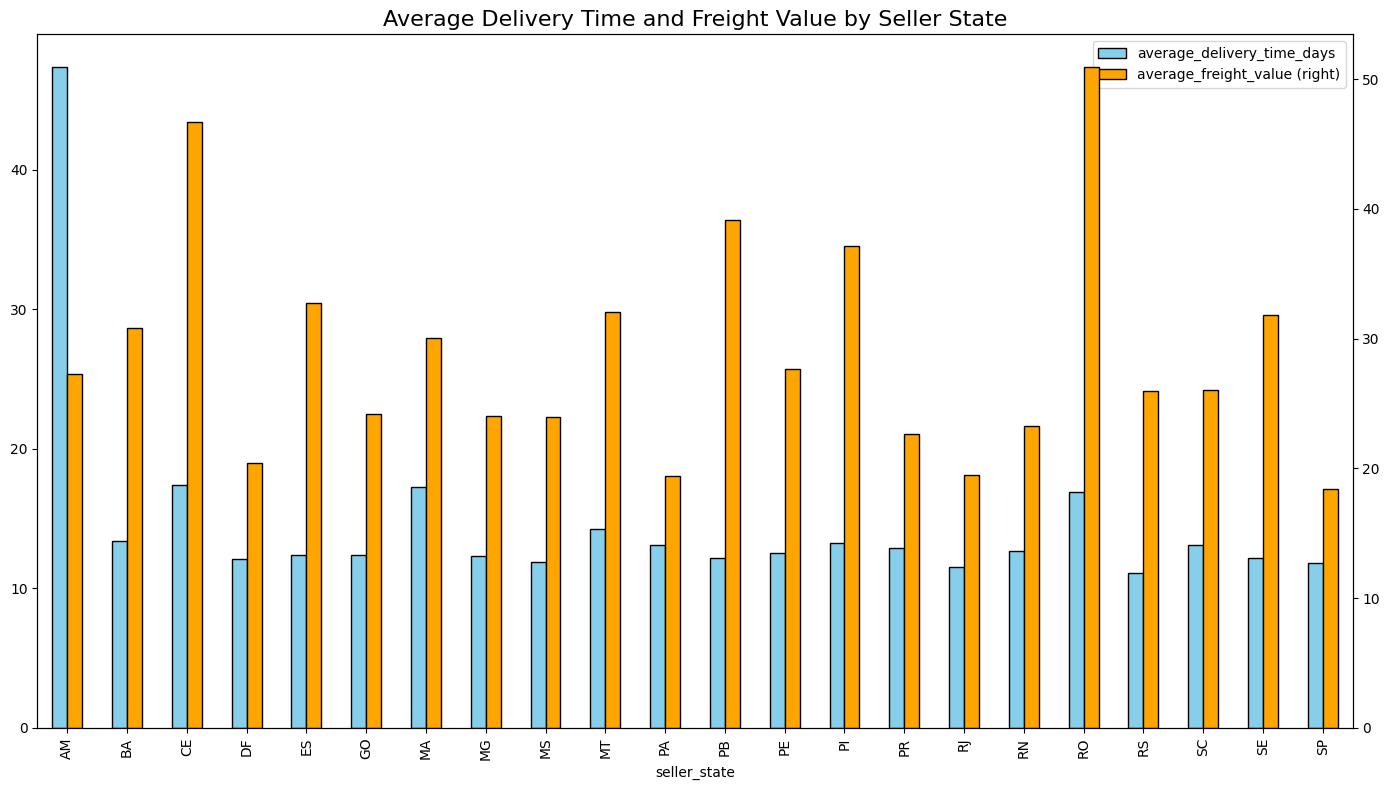

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: 데이터 로드
file_paths = {
    "order_items": "olist_order_items_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "orders": "olist_orders_dataset.csv"
}

# 데이터 로드
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# 데이터셋 할당
order_items = datasets['order_items']
sellers = datasets['sellers']
orders = datasets['orders']

# Step 2: 데이터 병합
# 판매자와 주문 아이템 데이터 병합
order_items_with_sellers = pd.merge(order_items, sellers, on='seller_id', how='left')

# 주문 데이터와 병합하여 배송 정보 포함
orders_with_sellers = pd.merge(order_items_with_sellers, orders, on='order_id', how='left')

# Step 3: 날짜 컬럼 변환 및 배송 시간 계산
# 날짜 컬럼을 datetime 형식으로 변환
date_columns = ['order_purchase_timestamp', 'order_delivered_customer_date']
for col in date_columns:
    orders_with_sellers[col] = pd.to_datetime(orders_with_sellers[col], errors='coerce')

# 배송 시간 계산 (일 단위)
orders_with_sellers['delivery_time_days'] = (orders_with_sellers['order_delivered_customer_date'] - orders_with_sellers['order_purchase_timestamp']).dt.days

# 유효한 배송 시간 데이터만 필터링
valid_seller_delivery_times = orders_with_sellers.dropna(subset=['delivery_time_days'])
valid_seller_delivery_times = valid_seller_delivery_times[valid_seller_delivery_times['delivery_time_days'] >= 0]

# Step 4: 주(State)별 평균 배송 시간 및 평균 운송비 계산
# 판매자 주(State)별 분석
seller_state_delivery = valid_seller_delivery_times.groupby('seller_state')['delivery_time_days'].mean().sort_values()
seller_state_freight = valid_seller_delivery_times.groupby('seller_state')['freight_value'].mean().sort_values()

# 결과 병합
seller_state_summary = pd.DataFrame({
    'average_delivery_time_days': seller_state_delivery,
    'average_freight_value': seller_state_freight
})

# Step 5: 결과 출력
print("판매자 주(State)별 평균 배송 시간 및 운송비 요약:")
print(seller_state_summary)

# Step 6: 시각화
seller_state_summary.plot(kind='bar', figsize=(14, 8), secondary_y='average_freight_value', color=['skyblue', 'orange'], edgecolor='black')
plt.title('Average Delivery Time and Freight Value by Seller State', fontsize=16)
plt.xlabel('Seller State', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 결과 분석
- 배송까지 걸리는 시간과 비용은 보통 비례하지만, 연관관계는 크게 찾아볼 수 없음. 

# 배송량과 배송 비용 간의 상관관계

주(State)별 주문량 및 평균 배송 비용:
                total_orders  average_freight_value
customer_state                                     
SP                     47449              15.147275
RJ                     14579              20.960924
MG                     13129              20.630167
RS                      6235              21.735804
PR                      5740              20.531652
SC                      4176              21.470369
BA                      3799              26.363959
DF                      2406              21.041355
GO                      2333              22.766815
ES                      2256              22.058777
PE                      1806              32.917863
CE                      1478              32.714202
PA                      1080              35.832685
MT                      1055              28.166284
MA                       824              38.257002
MS                       819              23.374884
PB                       602          

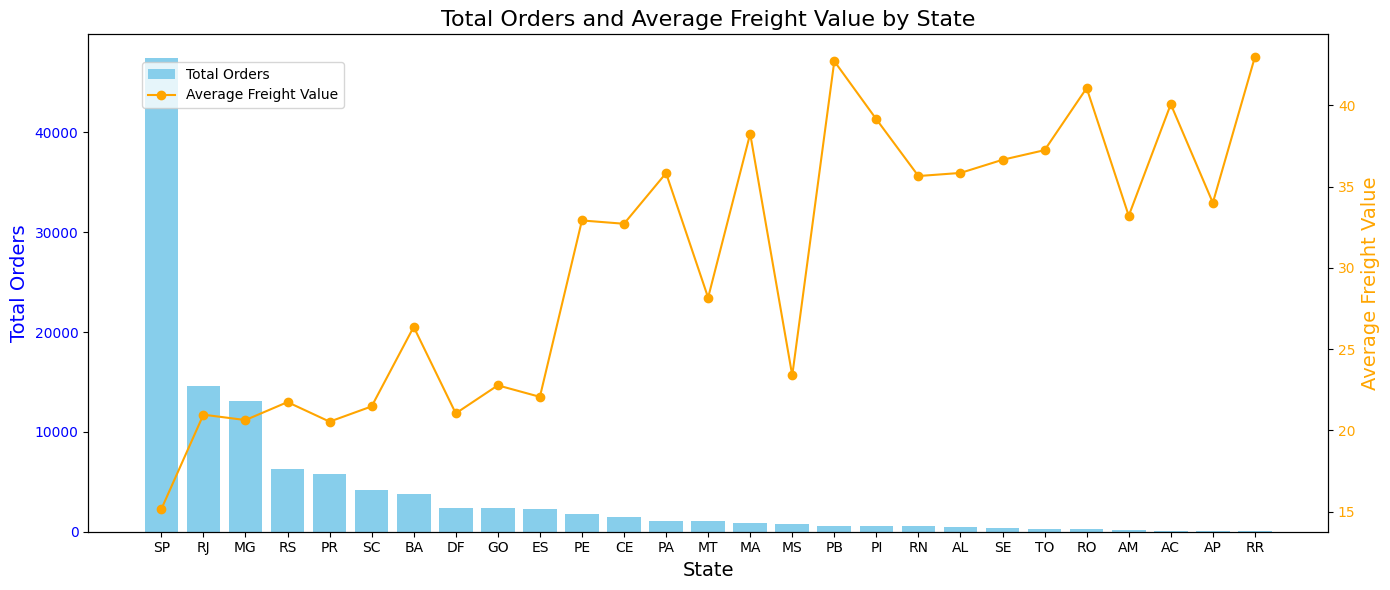

In [10]:
import pandas as pd

# Step 1: 데이터 불러오기
file_paths = {
    "order_items": "olist_order_items_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "orders": "olist_orders_dataset.csv",
    "customers": "olist_customers_dataset.csv"
}

# 데이터 로드
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# 데이터셋 할당
order_items = datasets['order_items']
sellers = datasets['sellers']
orders = datasets['orders']
customers = datasets['customers']

# Step 2: 데이터 병합
# 주문 정보에 고객 정보 추가
orders_with_customers = pd.merge(orders, customers, on='customer_id', how='left')

# 주문 아이템과 판매자 정보 병합
order_items_with_sellers = pd.merge(order_items, sellers, on='seller_id', how='left')

# 주문, 고객, 판매자 데이터를 병합하여 모든 정보 통합
complete_data = pd.merge(order_items_with_sellers, orders_with_customers, on='order_id', how='left')

# Step 3: 유효한 배송 비용과 주문 데이터 필터링
valid_data = complete_data.dropna(subset=['freight_value', 'order_id', 'customer_state'])

# Step 4: 주(State)별 주문량 및 평균 배송 비용 계산
state_summary = valid_data.groupby('customer_state').agg(
    total_orders=('order_id', 'count'),
    average_freight_value=('freight_value', 'mean')
).sort_values(by='total_orders', ascending=False)

# Step 5: 결과 출력
print("주(State)별 주문량 및 평균 배송 비용:")
print(state_summary)

# Step 6: 시각화
import matplotlib.pyplot as plt

# 그래프 설정
fig, ax1 = plt.subplots(figsize=(14, 6))

# 주문량 바 그래프
ax1.bar(state_summary.index, state_summary['total_orders'], color='skyblue', label='Total Orders')
ax1.set_xlabel('State', fontsize=14)
ax1.set_ylabel('Total Orders', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')

# 평균 배송 비용 선 그래프
ax2 = ax1.twinx()
ax2.plot(state_summary.index, state_summary['average_freight_value'], color='orange', marker='o', label='Average Freight Value')
ax2.set_ylabel('Average Freight Value', color='orange', fontsize=14)
ax2.tick_params(axis='y', labelcolor='orange')

# 타이틀 및 레전드 설정
plt.title('Total Orders and Average Freight Value by State', fontsize=16)
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

# 그래프 표시
plt.show()


### 결과 분석
- 배송이 적은 지역일수록 배송 금액이 높아짐

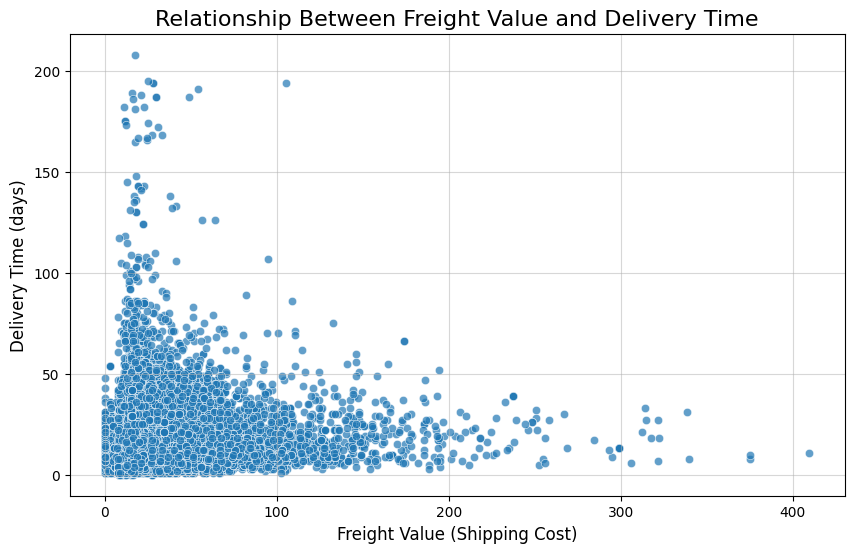

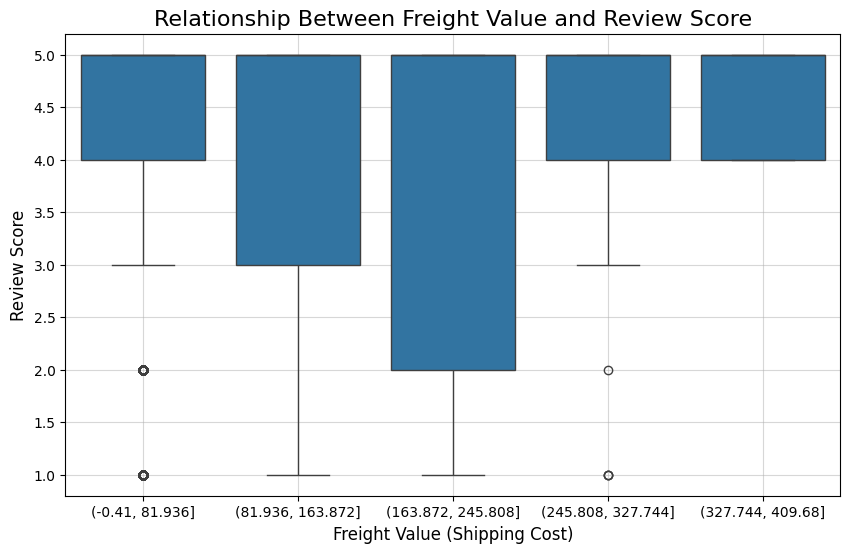

Correlation Matrix:
                    freight_value  delivery_time_days  review_score
freight_value            1.000000            0.215044     -0.032863
delivery_time_days       0.215044            1.000000     -0.304058
review_score            -0.032863           -0.304058      1.000000


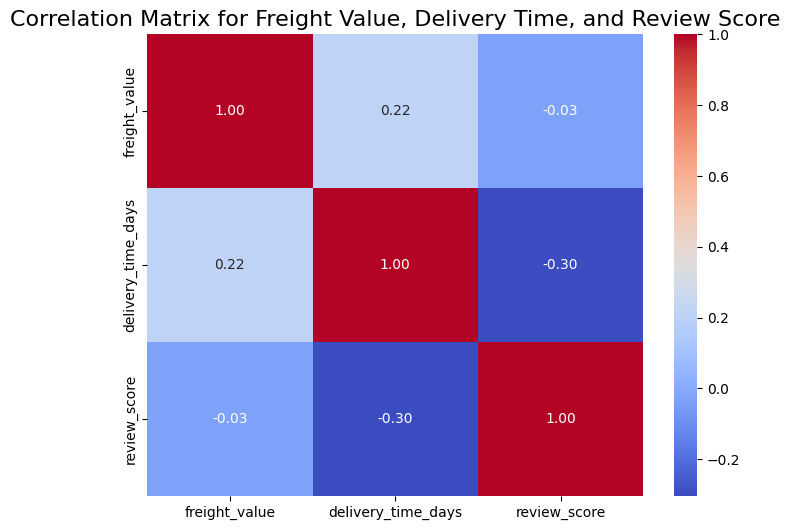

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: 데이터 불러오기
file_paths = {
    "order_items": "olist_order_items_dataset.csv",
    "orders": "olist_orders_dataset.csv",
    "order_reviews": "olist_order_reviews_dataset.csv"
}

# 데이터 로드
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# 데이터셋 할당
order_items = datasets['order_items']
orders = datasets['orders']
order_reviews = datasets['order_reviews']

# Step 2: 데이터 병합
# 주문 아이템과 주문 데이터 병합
order_items_with_orders = pd.merge(order_items, orders, on='order_id', how='left')

# 주문 데이터에 리뷰 데이터 병합
complete_data = pd.merge(order_items_with_orders, order_reviews, on='order_id', how='left')

# Step 3: 날짜 컬럼 변환 및 배송 시간 계산
# 날짜 컬럼을 datetime 형식으로 변환
date_columns = ['order_purchase_timestamp', 'order_delivered_customer_date']
for col in date_columns:
    complete_data[col] = pd.to_datetime(complete_data[col], errors='coerce')

# 배송 시간 계산 (일 단위)
complete_data['delivery_time_days'] = (complete_data['order_delivered_customer_date'] - complete_data['order_purchase_timestamp']).dt.days

# 유효한 데이터만 필터링
valid_data = complete_data.dropna(subset=['freight_value', 'delivery_time_days', 'review_score'])
valid_data = valid_data[valid_data['delivery_time_days'] >= 0]

# Step 4: 배송비와 배송 시간의 관계 분석
plt.figure(figsize=(10, 6))
sns.scatterplot(data=valid_data, x='freight_value', y='delivery_time_days', alpha=0.7)
plt.title('Relationship Between Freight Value and Delivery Time', fontsize=16)
plt.xlabel('Freight Value (Shipping Cost)', fontsize=12)
plt.ylabel('Delivery Time (days)', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Step 5: 배송비와 리뷰 점수의 관계 분석
plt.figure(figsize=(10, 6))
sns.boxplot(data=valid_data, x=pd.cut(valid_data['freight_value'], bins=5), y='review_score')
plt.title('Relationship Between Freight Value and Review Score', fontsize=16)
plt.xlabel('Freight Value (Shipping Cost)', fontsize=12)
plt.ylabel('Review Score', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Step 6: 상관관계 계산 (배송비, 배송 시간, 리뷰 점수)
correlation_matrix = valid_data[['freight_value', 'delivery_time_days', 'review_score']].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Step 7: 시각화 (상관관계 히트맵)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Freight Value, Delivery Time, and Review Score', fontsize=16)
plt.show()


In [22]:
pip install wordcloud


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\ckddu\AppData\Local\Temp\ipykernel_5756\528631489.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_score_reviews['keywords'] = low_score_reviews['review_comment_message'].apply(lambda x: extract_keywords(x, keywords))


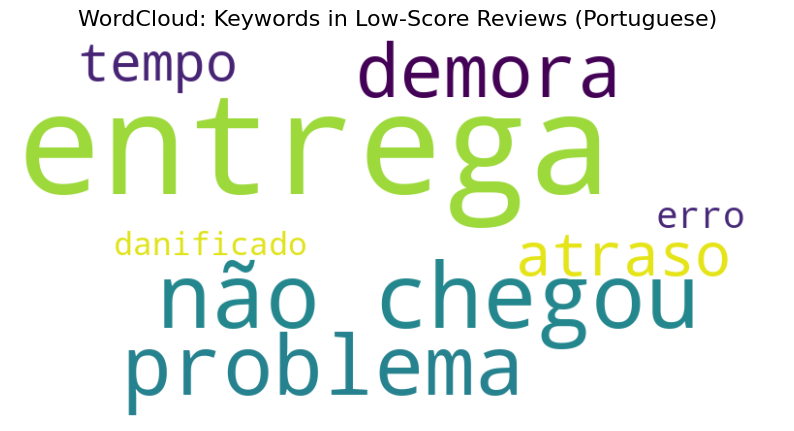

포르투갈어 배송 관련 키워드 빈도:
entrega: 1419회
demora: 255회
não chegou: 386회
problema: 330회
tempo: 123회
erro: 49회
atraso: 162회
danificado: 37회

낮은 점수 리뷰의 평균 배송 시간: 19.74일


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re

# Step 1: 데이터 불러오기
file_paths = {
    "orders": "olist_orders_dataset.csv",
    "order_reviews": "olist_order_reviews_dataset.csv"
}

# 데이터 로드
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# 데이터셋 할당
orders = datasets['orders']
order_reviews = datasets['order_reviews']

# Step 2: 데이터 병합
# 주문 데이터와 리뷰 데이터 병합
reviews_with_orders = pd.merge(order_reviews, orders, on='order_id', how='left')

# 날짜 컬럼 변환
reviews_with_orders['order_purchase_timestamp'] = pd.to_datetime(reviews_with_orders['order_purchase_timestamp'])
reviews_with_orders['order_delivered_customer_date'] = pd.to_datetime(reviews_with_orders['order_delivered_customer_date'])

# 배송 시간 계산 (일 단위)
reviews_with_orders['delivery_time_days'] = (reviews_with_orders['order_delivered_customer_date'] - reviews_with_orders['order_purchase_timestamp']).dt.days

# 유효한 데이터만 필터링
valid_reviews = reviews_with_orders.dropna(subset=['review_score', 'delivery_time_days'])
valid_reviews = valid_reviews[valid_reviews['delivery_time_days'] >= 0]

# Step 3: 낮은 점수 리뷰 텍스트 분석 (포르투갈어 키워드 사용)
# 낮은 점수(1~2점) 리뷰 필터링
low_score_reviews = valid_reviews[(valid_reviews['review_score'] == 1) | (valid_reviews['review_score'] == 2)]

# 포르투갈어 키워드 설정
keywords = ['atraso', 'demora', 'entrega', 'problema', 'erro', 'tempo', 'não chegou', 'danificado']

# 키워드 추출 함수
def extract_keywords(text, keyword_list):
    if pd.isna(text):
        return []
    return [word for word in keyword_list if word in text.lower()]

# 키워드 추출 및 빈도 계산
low_score_reviews['keywords'] = low_score_reviews['review_comment_message'].apply(lambda x: extract_keywords(x, keywords))
all_keywords = Counter([word for sublist in low_score_reviews['keywords'] for word in sublist])

# Step 4: 키워드 시각화 (워드클라우드)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(all_keywords)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud: Keywords in Low-Score Reviews (Portuguese)', fontsize=16)
plt.show()

# Step 5: 결과 요약
print("포르투갈어 배송 관련 키워드 빈도:")
for word, count in all_keywords.items():
    print(f"{word}: {count}회")

# Step 6: 낮은 리뷰 점수와 평균 배송 시간 출력
avg_delivery_time_low_reviews = low_score_reviews['delivery_time_days'].mean()
print(f"\n낮은 점수 리뷰의 평균 배송 시간: {avg_delivery_time_low_reviews:.2f}일")


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: 데이터 불러오기
file_paths = {
    "products": "/mnt/data/olist_products_dataset.csv",
    "order_items": "/mnt/data/olist_order_items_dataset.csv",
    "orders": "/mnt/data/olist_orders_dataset.csv",
    "order_reviews": "/mnt/data/olist_order_reviews_dataset.csv"
}

# 데이터 로드
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# 데이터셋 할당
products = datasets['products']
order_items = datasets['order_items']
orders = datasets['orders']
order_reviews = datasets['order_reviews']

# Step 2: 데이터 병합
# 주문 아이템에 제품 카테고리 병합
order_items_with_products = pd.merge(order_items, products, on='product_id', how='left')

# 주문 데이터 병합 (배송 정보 포함)
orders_with_items = pd.merge(order_items_with_products, orders, on='order_id', how='left')

# 리뷰 데이터 병합 (리뷰 점수 포함)
complete_data = pd.merge(orders_with_items, order_reviews, on='order_id', how='left')

# 날짜 컬럼 변환
complete_data['order_purchase_timestamp'] = pd.to_datetime(complete_data['order_purchase_timestamp'])
complete_data['order_delivered_customer_date'] = pd.to_datetime(complete_data['order_delivered_customer_date'])

# 배송 시간 계산 (일 단위)
complete_data['delivery_time_days'] = (complete_data['order_delivered_customer_date'] - complete_data['order_purchase_timestamp']).dt.days

# 유효한 데이터 필터링
valid_data = complete_data.dropna(subset=['delivery_time_days', 'review_score', 'product_category_name'])
valid_data = valid_data[valid_data['delivery_time_days'] >= 0]

# Step 3: 카테고리별 평균 배송 시간 분석
category_delivery_time = valid_data.groupby('product_category_name')['delivery_time_days'].mean().sort_values(ascending=False)

# 시각화: 카테고리별 평균 배송 시간
plt.figure(figsize=(12, 8))
category_delivery_time.head(15).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 15 Product Categories by Average Delivery Time', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Average Delivery Time (days)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 4: 카테고리별 배송 문제 비율 분석 (리뷰 점수 1~2점)
valid_data['is_low_review'] = valid_data['review_score'] <= 2
category_problem_rate = valid_data.groupby('product_category_name')['is_low_review'].mean().sort_values(ascending=False)

# 시각화: 카테고리별 배송 문제 비율
plt.figure(figsize=(12, 8))
category_problem_rate.head(15).plot(kind='bar', color='orange', edgecolor='black')
plt.title('Top 15 Product Categories with High Delivery Problems (Low Review Scores)', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Proportion of Low Review Scores', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 5: 카테고리별 배송 지연 비율 분석 (15일 초과)
valid_data['is_delayed'] = valid_data['delivery_time_days'] > 15
category_delay_rate = valid_data.groupby('product_category_name')['is_delayed'].mean().sort_values(ascending=False)

# 시각화: 카테고리별 배송 지연 비율
plt.figure(figsize=(12, 8))
category_delay_rate.head(15).plot(kind='bar', color='red', edgecolor='black')
plt.title('Top 15 Product Categories with High Delivery Delay Rates (>15 days)', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Proportion of Delayed Orders', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 6: 결과 요약 출력
print("Top 5 Product Categories with Longest Average Delivery Time:")
print(category_delivery_time.head(5))

print("\nTop 5 Product Categories with Highest Delivery Problem Rate (Low Reviews):")
print(category_problem_rate.head(5))

print("\nTop 5 Product Categories with Highest Delivery Delay Rate (>15 days):")
print(category_delay_rate.head(5))


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/olist_products_dataset.csv'